###  Kittylyst demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs
%matplotlib inline

In [2]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [3]:
# from kittylyst import (
#     MicroLoader, MicroCriterion, MicroOptimizer, MicroScheduler,
#     SingleStageExperiment, IRunner,SupervisedRunner, ICallback,
#     CriterionCallback, AccuracyCallback, 
#     OptimizerCallback, SchedulerCallback,
#     LoggerCallback
# )

In [4]:
from kittylyst import *

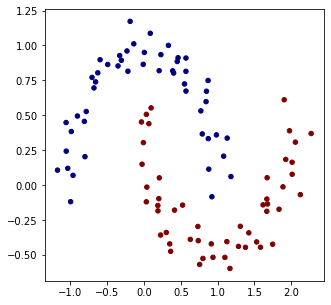

In [5]:
# make up a dataset
def make_dataset(seed=42, n_samples=100):
    np.random.seed(seed)
    random.seed(seed)
    X, y = make_moons(n_samples=100, noise=0.1)

    y = y*2 - 1 # make y be -1 or 1
    return X, y

def visualize_dataset(X, y):
    plt.figure(figsize=(5,5))
    plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

# let's create train data
X_train, y_train = make_dataset()
visualize_dataset(X_train, y_train)

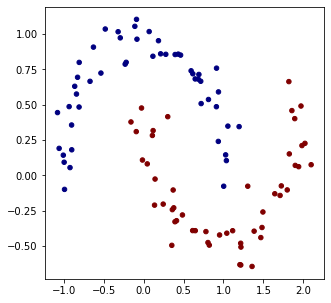

In [6]:
# valid data
X_valid, y_valid = make_dataset(seed=137)
visualize_dataset(X_valid, y_valid)

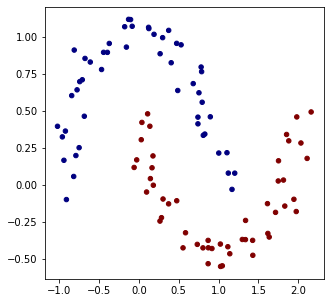

In [7]:
# and another train one (why not?)
X_train2, y_train2 = make_dataset(seed=1337)
visualize_dataset(X_train2, y_train2)

In [8]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [9]:
def visualize_decision_boundary(X, y, model):
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Value, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

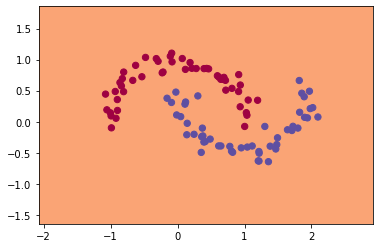

In [10]:
visualize_decision_boundary(X_valid, y_valid, model)

In [11]:
loaders = {
    "train_1": MicroLoader(X_train, y_train), 
    "train_2": MicroLoader(X_train2, y_train2), 
    "valid": MicroLoader(X_valid, y_valid), 
}

---

### Act 1 - ``CustomRunner`` solution

Suppose you have your favorite `for-loop` pipeline and want to get rid of `for-for-for` stuff to make code more clean. In this case you can define your own ``CustomRunner`` with ``_handle_batch`` method and just run it.

Whole ``Runner`` source code is located [here](github.com/Scitator/kittylyst/blob/master/kittylyst/runner.py) (~100 lines of code).

In [ ]:
model = MLP(2, [16, 16, 1])
experiment = SingleStageExperiment(model=model, loaders=loaders, num_epochs=10)

class CustomRunner(IRunner):
    def _handle_batch(self, batch):
        features, targets = batch
        scores = list(map(self.model, features))
        
        losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(targets, scores)]
        data_loss = sum(losses) * (1.0 / len(losses))
        # L2 regularization
        alpha = 1e-4
        reg_loss = alpha * sum((p*p for p in self.model.parameters()))
        total_loss = data_loss + reg_loss

        # also get accuracy
        accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(targets, scores)]
        accuracy = sum(accuracy) / len(accuracy)
        
        print(f"{self.loader_key}: accuracy {accuracy}, loss {total_loss.data}")
        
        if self.is_train_loader:
            # backward
            self.model.zero_grad()
            total_loss.backward()

            # update (sgd)
            learning_rate = 1.0 - 0.9 * self.stage_epoch / self.stage_len
            for p in self.model.parameters():
                p.data -= learning_rate * p.grad

CustomRunner().run_experiment(experiment)

In [ ]:
visualize_decision_boundary(X_valid, y_valid, model)

---

### Act 2 - ``SupervisedRunner`` solution

Let's make a bit more abstract. Let's introduce ``SupervisedRunner``, that knows how to execute Supervised models and ``CriterionCallback/OptimizerCallback/SchedulerCallback`` for typical criterions/optimizers/schedulers steps. 

Additionaly let's wrap accuracy with ``AccuracyCallback``, as far as metrics are general too. 

Finally, let's make our logs looks consistent with ``LoggerCallback``.

Whole ``Callback`` source code is located [here](github.com/Scitator/kittylyst/blob/master/kittylyst/callback.py) (~100 lines of code).

In [12]:
model = MLP(2, [16, 16, 1])
criterion = MicroCriterion()
optimizer = MicroOptimizer(model)
scheduler = MicroScheduler(optimizer, num_epochs=10)
experiment = SingleStageExperiment(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    loaders=loaders, 
    num_epochs=10,
    callbacks={
        "criterion": CriterionCallback(), 
        "accuracy": MetricCallback(metric=AccuracyMetric(), input_key="targets", output_key="logits"), 
        "optimizer": OptimizerCallback(), 
        "scheduler": SchedulerCallback(),
#         "verbose": VerboseCallback(),
        "top-n-epochs": TopNMetricHandlerCallback(
            loader_key="valid", metric_key="loss_mean", 
            minimize=True, save_n_best=3
        ),
    },
    loggers={
#         "console": ConsoleLogger(exclude=["batch", "global_batch", "loader", "global_epoch"]),
        "console": ConsoleLogger(include=["loader"]),
    }
)

SupervisedRunner().run_experiment(experiment)

Hparams: {}
train_1 (1/10) accuracy_mean: 0.28125000000000006 accuracy_std: 0.059385568684867183 loss_mean: 1.2394082237465172 loss_std: 0.06074673936262456
train_2 (1/10) accuracy_mean: 0.303125 accuracy_std: 0.05246658886099291 loss_mean: 1.2027645315735132 loss_std: 0.045884741530854485
valid (1/10) accuracy_mean: 0.359375 accuracy_std: 0.07306811783028347 loss_mean: 1.1652235018399324 loss_std: 0.06230078558396885
train_1 (2/10) accuracy_mean: 0.79375 accuracy_std: 0.15088557810556574 loss_mean: 0.5286944419921031 loss_std: 0.3011942432812098
train_2 (2/10) accuracy_mean: 0.9187500000000001 accuracy_std: 0.034853027735330985 loss_mean: 0.2026483571410789 loss_std: 0.06909449391893162
valid (2/10) accuracy_mean: 0.915625 accuracy_std: 0.02816904857828256 loss_mean: 0.3028984907725882 loss_std: 0.11085518424631934
train_1 (3/10) accuracy_mean: 0.93125 accuracy_std: 0.030666575802872978 loss_mean: 0.19535584213821872 loss_std: 0.06897594009164253
train_2 (3/10) accuracy_mean: 0.959375

In [ ]:
visualize_decision_boundary(X_valid, y_valid, model)

---

### Act 3 - ``CustomExperiment`` solution - multi-stage experiment with ``VisualizationCallback``

Let's go even harder. Suppose we want to firstly train our model on `train_1` data, and only after that - on `train_2`. This case could be easily handled with ``CustomExperiment``, where you could redefine your experiment components for each stage of your experiment.

Whole ``Experiemnt`` source code is located [here](github.com/Scitator/kittylyst/blob/master/kittylyst/experiment.py) (~100 lines of code).

In [ ]:
class CustomExperiment(Experiment):
    @property
    def stages(self):
        return self._stage

    def get_loaders(self, stage: str):
        return self._loaders[stage]

    
class VisualizationCallback(Callback):
    def on_stage_end(self, runner):
        visualize_decision_boundary(X_valid, y_valid, runner.model)


loaders = {
    "loader_1": {
        "train_1": MicroLoader(X_train, y_train), 
        "valid": MicroLoader(X_valid, y_valid), 
    },
    "loader_2": {
        "train_2": MicroLoader(X_train2, y_train2), 
        "valid": MicroLoader(X_valid, y_valid), 
    },
}
model = MLP(2, [16, 16, 1])
criterion = MicroCriterion()
optimizer = MicroOptimizer(model)
scheduler = MicroScheduler(optimizer, num_epochs=10)
experiment = CustomExperiment(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    loaders=loaders, 
    num_epochs=10,
    callbacks=[
        CriterionCallback(), 
        AccuracyCallback(), 
        OptimizerCallback(), 
        SchedulerCallback(),
        LoggerCallback(),
        VisualizationCallback(),  # <-- here is our new Callback
    ],
    verbose=False,
    stage=loaders.keys()  # <-- here is the trick for multi-stage support
)

SupervisedRunner().run_experiment(experiment)

In [ ]:
visualize_decision_boundary(X_valid, y_valid, model)

---

🎉 You have passed ``Kittylyst`` tutorial! This is just a minimal educational demo, but I hope you found it interesting for your deep learning research code organisation.

For more advanced and production-ready solution please follow our [Catalyst](https://github.com/catalyst-team/catalyst) repository.

PS. If you are interested in deep learning you could also try out our [dl-course](https://github.com/catalyst-team/dl-course).